In [1]:
import numpy as np
import scipy.io
import pickle
import matplotlib.pyplot as plt
from stablab import (semicirc, winding_number, Evans_plot, emcset,
                       Evans_compute, Struct, reflect_image)
from stablab.wave_profile import profile_flux, soln
from stablab.root_finding import moments_roots
from stablab.evans import LdimRdim
from stablab.contour import Evans_plot_mult

In [2]:
from MHD2 import profile_ode, profile_jacobian
from MHD2 import A_evans, A_lop, A_jump, Ak

In [3]:
np.set_printoptions(suppress=True)

# Initialize Parameters

1.05 0.5 0.0980265306122449

1.05 0.55 0.11638775510204083

1.05 0.6 0.18371224489795918

1.1 0.5 0.1041469387755102

1.1 0.55 0.12250816326530611

1.1 0.75 0.0001

1.15 0.5 0.11026734693877552

1.15 0.55 0.13474897959183674

1.2 0.5 0.12250816326530611

1.4 0.8 0.012340816326530613

1.4 0.95 0.0001

1.8 0.8500000000000001 0.024581632653061236

In [73]:
# Parameters
def setParams():
    p = Struct({'h1': 1.45,
            'Gamma': Gamma, 
            'v_plus': .8,
            'mu': .1,
            'eta': -2/3*mu,
            'cnu': cnu,
            'R': cnu*Gamma,
            'alpha':1,
            'kappa': .1 })
    p.update({
            'v_star': p['Gamma']/(p['Gamma']+2) # 3.14
            })
    p.update({
            'e_plus': p['v_plus']*(p['Gamma']+2-p['Gamma']*p['v_plus'])/(2*p['Gamma']*(p['Gamma']+1)), # 3.15
            'e_minus': (p['Gamma']+2)*(p['v_plus']-p['v_star'])/(2*p['Gamma']*(p['Gamma']+1)), # 3.16
            'v_minus': 1,
            'nu': p['kappa']/p['cnu'] # see below 2.25
            })
    p.update({
            'UR': [1/p['v_plus'],p['v_plus'],0,p['h1'],0,p['e_plus']/p['cnu']],
            'UL': [1/p['v_minus'],p['v_minus'],0,p['h1'],0,p['e_minus']/p['cnu']]
            })
    return p

# Inputs
# L = 10
# X_STEPS = 200
Gamma = 2/3#.666 # for 2/3 winding num = 1
cnu = 1
mu = .1
p = setParams()

# Initialising sol, the Struct with solution values
sol = Struct({
    'n': 2, # this is the dimension of the profile ode
    # we divide the domain in half to deal with the
    # non-uniqueness caused by translational invariance
    # sol.side = 1 means we are solving the profile on the interval [0,X]
    'side': 1,
    'F': profile_ode, # F is the profile ode
    'Flinear': profile_jacobian, # J is the profile ode Jacobian
    'UL': np.array([p['v_minus'],p['e_minus']]), # These are the endstates of the profile and its derivative at x = -infty
    'UR': np.array([p['v_plus'],p['e_plus']]), # These are the endstates of the profile and its derivative at x = +infty
    'tol': 1e-7,
    'xi': 1,
    'system' : 'parallel',
    'mat_type' : 'mbfv',
    'tol':1e-5
    })
sol.update({
    'phase': 0.5*(sol['UL']+sol['UR']), # this is the phase condition for the profile at x = 0
    'order': [1], # this indicates to which component the phase conditions is applied
    'stats': 'on', # this prints data and plots the profile as it is solved
    'bvp_options': {'Tol': 1e-8, 'Nmax': 20000},
    'L_max': 10000,
    'R_max': 10000
    })

# Solve Profile

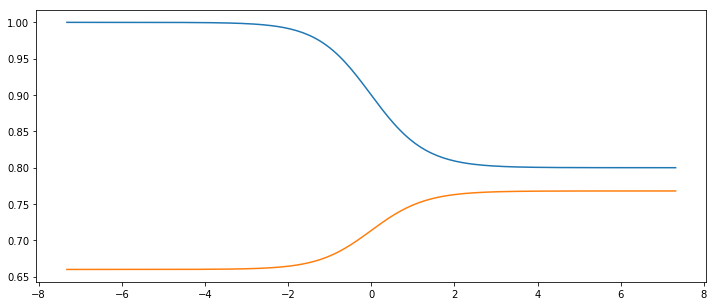

In [74]:
# Solve the profile
sol['stats'] = 'off'
p, s_org = profile_flux(p, sol)

# Plot the profile
x = np.linspace(s_org['L'],s_org['R'],200)
y = soln(x,s_org)

plt.figure("Profile")
plt.plot(x,y)
plt.show()

# Evaluate Evans Function

Finding the kato basis


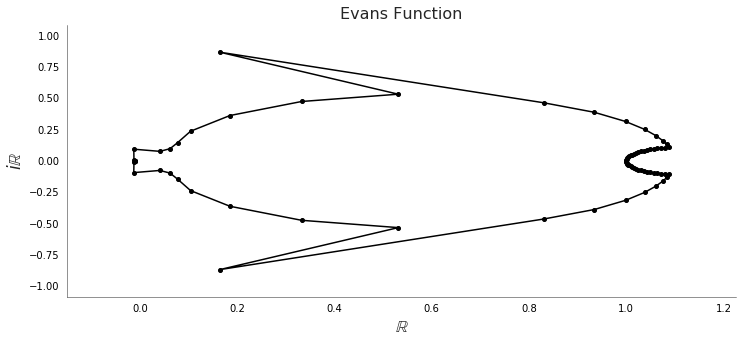

Winding Number: 1.000000

Roots: -1.0772937675144933e-06



In [75]:
# Set up Stablab structures
# s, e, m, c = emcset(s,'front',[5,6],'reg_reg_polar',A)
try:
    Ldim,Rdim = LdimRdim(A_evans, s_org, p)
except:
    Ldim, Rdim = 5,6
s, e, m, c = emcset(s_org,'front',[Ldim,Rdim],'default',A_evans)

m['options'] = {}
m['options']['RelTol'] = 1e-10
m['options']['AbsTol'] = 1e-12

# refine the Evans function computation to achieve set relative error
c['refine'] = 'off';

s['xi'] = .0001

# display a waitbar
c['stats'] = 'print'
# c['stats'] = 'on'
c['ksteps'] = 2**6
c['lambda_steps'] = 2**8

c['tol'] = 0.01
c['check'] = 'off'
c['parallel'] = 'off'

# Set up the preimage
circpnts, imagpnts, innerpnts = 20, 20, 32
r = .001
spread = 4
zerodist = 0#10**(-4)
preimage = semicirc(circpnts, imagpnts, c['ksteps'], r, spread, zerodist,c['lambda_steps'])#+shift

# Compute the Evans function
out, domain = Evans_compute(preimage,c,s,p,m,e)

# Normalize and plot the Evans function
out = out/out[0]
w = reflect_image(out)
Evans_plot(w,titlestring='Evans Function')

windnum = winding_number(w)

print('Winding Number: {:f}\n'.format(windnum))

rts = moments_roots(domain,w).real
print('Roots: {}\n'.format(rts))

In [7]:
# # syntax for comparing code to matlab output
# U1_py = np.load('U1.npy')
# U1_ml = scipy.io.loadmat('check.mat')['US']
# print(U1_py.shape)
# print(U1_ml.shape)
# print(np.linalg.norm(U1_py-U1_ml))

In [8]:
evans_w = w.copy()

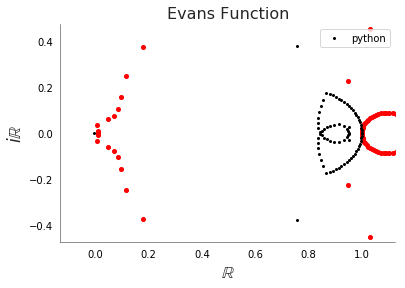

4.524536169994575


In [9]:
matlab_w = scipy.io.loadmat('evan_18_85.mat')['tosave']
Evans_plot_mult(evans_w,matlab_w,titlestring='Evans Function',figname='compare_evans_18_85.png')
print(np.linalg.norm(matlab_w-evans_w))

# Evaluate Lopatinski Determinant

In [79]:
p.nu

0.1

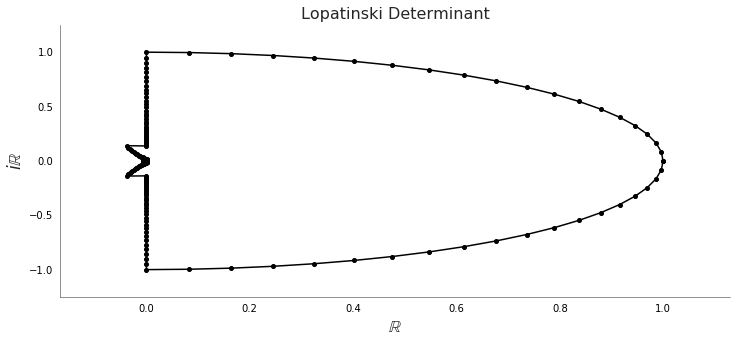

Winding Number: 1.000000

Roots: -0.09670177561562168



In [51]:
# Set up Stablab structures
# s, e, m, c = emcset(s,'front',[5,6],'reg_reg_polar',A)
Ldim,Rdim = LdimRdim(A_lop, s_org, p)
s, e, m, c = emcset(s_org,'lopatinski',[Ldim,Rdim],'default',A_lop)

# set the lopatinski jump condition
e['jump'] = A_jump

s['xi'] = 1
s['R'] = 1
s['L'] = -1

# refine the Evans function computation to achieve set relative error
c['refine'] = 'off';

# display a waitbar
# c['stats'] = 'print'
# c['stats'] = 'on'
c['ksteps'] = 2**8

c['tol'] = 0.1

# Set up the preimage
circpnts, imagpnts, innerpnts = 20, 80, 32
r = 10
shift = 1e-5
spread = 4
zerodist = 0#10**(-4)
# ksteps, lambda_steps = 32, 0
preimage = semicirc(circpnts, imagpnts, c['ksteps'], r, spread, zerodist)+shift

# Compute the Evans function
out0, domain = Evans_compute(preimage,c,s,p,m,e)

# Normalize and plot the Evans function
out = out0/out0[0]
w = reflect_image(out)
prew = reflect_image(domain)
Evans_plot(w,titlestring='Lopatinski Determinant')

windnum = winding_number(w)
print('Winding Number: {:f}\n'.format(windnum))

rts = moments_roots(prew,w).real
print('Roots: {}\n'.format(rts))

In [11]:
lop_w = w.copy()

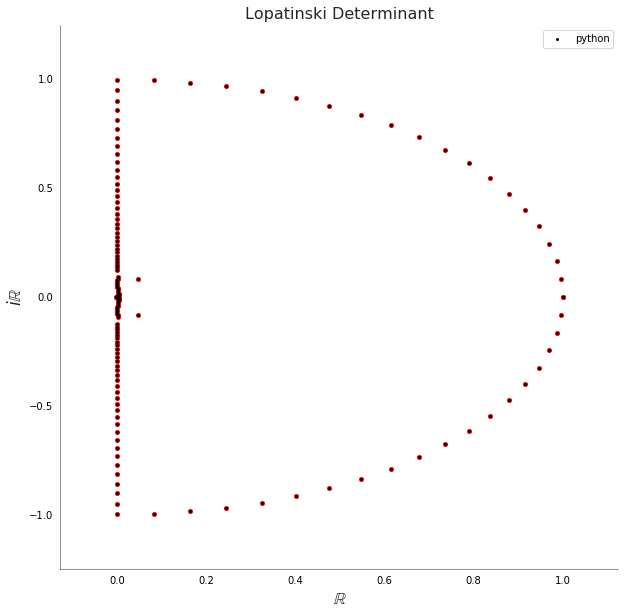

2.2583629705836033e-12


In [21]:
matlab_w = scipy.io.loadmat('lop_14_8.mat')['tosave']
Evans_plot_mult(lop_w,matlab_w,titlestring='Lopatinski Determinant',figname='compare_evans_18_85.png')
print(np.linalg.norm(matlab_w-lop_w))

In [64]:
def fill_dictionary(d,h1_vals,vp_vals,output):
    # loop through h1vp pairs
    for h1vp in output.keys():
        h1,vp = h1vp.split()
        h1,vp = float(h1),float(vp)
        
        if h1 == 1.01: h1 = 1
        if vp == .99: vp = 1
#         print(h1)

        # get h1 and vp
        h1_vals.append(h1)
        vp_vals.append(vp)

        # get lop winding number
        lop_d = output[h1vp]['lop']
        if lop_d is not None:
            lop_wnd = lop_d['wnd']
        else:
            lop_wnd = None

        # get evans winding number
        evn_d = output[h1vp]['evans']
        if evn_d is not None:
            evn_wnd = evn_d['wnd']
        else:
            evn_wnd = None
            
        if evn_wnd != None and lop_wnd != None:
            if lop_wnd == 0 and evn_wnd > 0:
#                 print(evn_d['xi'])
                xi = round(evn_d['xi'],10)
                R = lop_d['R']
                print(h1,vp,evn_wnd,xi,lop_wnd,R,sep='\t')

        # store winding numbers
        wnd_nums = [lop_wnd,evn_wnd]
        if h1 in d.keys():
            d[h1][vp] = wnd_nums
        else:
            d[h1] = {vp:wnd_nums}
            
#     print(set(h1_vals))
    return d, h1_vals,vp_vals

In [67]:
def view_batch_results(b_num):
    
    print('h1\tvp\tEvans\txi\tLop\tR')
    # new dictionary
    d = {}

    # storage for h1 and vp
    h1_vals = []
    vp_vals = []
    
    if isinstance(b_num,list):
        for bn in b_num:
            filename = 'output/batch{}.pkl'.format(bn)
            load = pickle.load(open(filename,'rb'))
            d, h1_vals, vp_vals = fill_dictionary(d,h1_vals,vp_vals,load)
    else:
        filename = 'output/batch{}.pkl'.format(b_num)
        load = pickle.load(open(filename,'rb'))
        d, h1_vals, vp_vals = fill_dictionary(d,h1_vals,vp_vals,load)

    # remove duplicate h1,vp values
    h1_vals = list(set(h1_vals))
    vp_vals = list(set(vp_vals))
    
    fig = plt.figure()
    
    plt.rcParams['figure.figsize'] = 12,5
    
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0],marker='o', color='w',markerfacecolor='lightsteelblue'),
                    Line2D([0], [0],marker='o', color='w',markerfacecolor='C0'),
                    Line2D([0], [0],marker='o', color='w',markerfacecolor='lightgreen'),
                    Line2D([0], [0],marker='o', color='w',markerfacecolor='C2')]

#     plt.subplot(121)
    for h1 in h1_vals:
        for vp in vp_vals:
#             if d[h1][vp][0] == 0 and d[h1][vp][1] == 1:
#                 print(h1,vp)
            try:
                wnd = d[h1][vp][0]
                if wnd == 0:
                    plt.plot(vp-.002,h1,'.',color='lightsteelblue')
                elif wnd == 1:
                    plt.plot(vp-.002,h1,'.C0')
            except:
                plt.plot(vp-.002,h1,'.C0')
#                 print(h1,vp,'no lopatinski winding number')
    plt.title('Lopatinski Winding Numbers')
    plt.xlabel(r'$u_+$')
    plt.ylabel(r'$h_1$')

#     plt.subplot(122)
    for h1 in h1_vals:
        for vp in vp_vals:
            try:
                wnd = d[h1][vp][1]
                if wnd == 0:
                    plt.plot(vp+.002,h1,'.',color='lightgreen')
                elif wnd == 1:
                    plt.plot(vp+.002,h1,'.C2')
            except:
                plt.plot(vp+.002,h1,'.C2')
#                 print(h1,vp,'no evans winding number')
    plt.title('Stability Comparison')
    plt.xlabel(r'$u_+$')
    plt.ylabel(r'$h_1$')
    
    legend_x = 1
    legend_y = 0.5
#     plt.rcParams['figure.figsize'] = 15,10
    plt.legend(custom_lines, ['Stable Inviscid','Unstable Inviscid','Stable Viscous','Unstable Viscous'], loc='center left', bbox_to_anchor=(legend_x, legend_y))
    
#     plt.xlim(0,.0101)
#     plt.xlim(.59,1.01)
    plt.tight_layout()
    plt.savefig('stability.png',dpi=100)
    plt.show()

h1	vp	Evans	xi	Lop	R
1.4	0.8	1	0.0001	0	10
3.75	1	1	0.0001	0	10


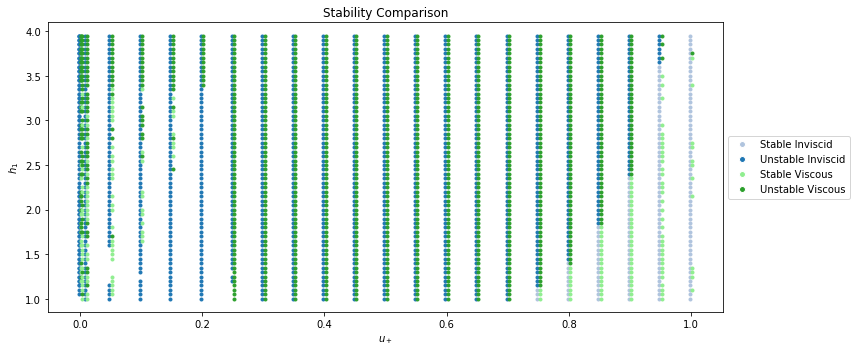

In [68]:
view_batch_results([0,1,2,3,4,5,6,7,8,9,10,11])

In [31]:
np.argmax([1,2])

1

In [80]:
filename = 'output/batch{}.pkl'.format(0)
load = pickle.load(open(filename,'rb'))

In [87]:
for key in load.keys():
    print(load[key]['lop']['p']['nu'])
    print(load[key]['evans']['p']['nu'])
    break

0.1
0.1
